In [1]:
import pandas as pd
from glob import glob
import numpy as np
import os                                                                                                           
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('./dataset/Data_Entry_2017.csv')

In [53]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [55]:
df = df.loc[:,['Image Index','Patient ID', 'Finding Labels']]
df

,Image Index,Patient ID,Finding Labels
0,00000001_000.png,1,Cardiomegaly
1,00000001_001.png,1,Cardiomegaly|Emphysema
2,00000001_002.png,1,Cardiomegaly|Effusion
3,00000002_000.png,2,No Finding
4,00000003_000.png,3,Hernia
...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia
112116,00030802_000.png,30802,No Finding
112117,00030803_000.png,30803,No Finding
112118,00030804_000.png,30804,No Finding


In [56]:
img_paths={os.path.basename(x): x for x in glob(os.path.join('.', 'dataset', 'images*','images','*.png'))} #img_paths={os.path.basename(x): x for x in glob(os.path.join('.', '/content/dataset/','images*', '*', '*.png'))}

In [37]:
# img_paths={os.path.basename(x): x for x in glob(os.path.join('.', 'simular_100', 'images','*.png'))} #img_paths={os.path.basename(x): x for x in glob(os.path.join('.', '/content/dataset/','images*', '*', '*.png'))}

In [58]:
df['path']=df['Image Index'].map(img_paths.get)#mapping image ids to all image paths
df

,Image Index,Patient ID,Finding Labels,path
0,00000001_000.png,1,Cardiomegaly,./dataset/images_001/images/00000001_000.png
1,00000001_001.png,1,Cardiomegaly|Emphysema,./dataset/images_001/images/00000001_001.png
2,00000001_002.png,1,Cardiomegaly|Effusion,./dataset/images_001/images/00000001_002.png
3,00000002_000.png,2,No Finding,./dataset/images_001/images/00000002_000.png
4,00000003_000.png,3,Hernia,./dataset/images_001/images/00000003_000.png
...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,./dataset/images_012/images/00030801_001.png
112116,00030802_000.png,30802,No Finding,./dataset/images_012/images/00030802_000.png
112117,00030803_000.png,30803,No Finding,./dataset/images_012/images/00030803_000.png
112118,00030804_000.png,30804,No Finding,./dataset/images_012/images/00030804_000.png


In [61]:
labels = df['Finding Labels'].str.get_dummies('|')
df = pd.concat([df, labels], axis=1)
df

,Image Index,Patient ID,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,Cardiomegaly,./dataset/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,Cardiomegaly|Emphysema,./dataset/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,Cardiomegaly|Effusion,./dataset/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,No Finding,./dataset/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,3,Hernia,./dataset/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,30801,Mass|Pneumonia,./dataset/images_012/images/00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,30802,No Finding,./dataset/images_012/images/00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,30803,No Finding,./dataset/images_012/images/00030803_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,30804,No Finding,./dataset/images_012/images/00030804_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [62]:
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = df['Patient ID'].values

train_idxs, test_idxs = next(split.split(df, groups=groups))

df_train = df.iloc[train_idxs]
df_test = df.iloc[test_idxs]

In [63]:
split = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
groups = df_train['Patient ID'].values

train_idxs, val_idxs = next(split.split(df_train, groups=groups))

df_train_atualizado = df_train.iloc[train_idxs]
df_val = df_train.iloc[val_idxs]

In [64]:
df_train_atualizado

,Image Index,Patient ID,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,Cardiomegaly,./dataset/images_001/images/00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,Cardiomegaly|Emphysema,./dataset/images_001/images/00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,Cardiomegaly|Effusion,./dataset/images_001/images/00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,No Finding,./dataset/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,3,Hernia,./dataset/images_001/images/00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,30800,No Finding,./dataset/images_012/images/00030800_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112114,00030801_000.png,30801,No Finding,./dataset/images_012/images/00030801_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112115,00030801_001.png,30801,Mass|Pneumonia,./dataset/images_012/images/00030801_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,30802,No Finding,./dataset/images_012/images/00030802_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [65]:
df_val

,Image Index,Patient ID,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
175,00000033_000.png,33,Atelectasis|Cardiomegaly|Fibrosis,./dataset/images_001/images/00000033_000.png,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
181,00000037_000.png,37,No Finding,./dataset/images_001/images/00000037_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
199,00000041_000.png,41,Emphysema|Infiltration,./dataset/images_001/images/00000041_000.png,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
200,00000041_001.png,41,Emphysema,./dataset/images_001/images/00000041_001.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
201,00000041_002.png,41,Emphysema|Pneumothorax,./dataset/images_001/images/00000041_002.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112005,00030726_000.png,30726,Nodule,./dataset/images_012/images/00030726_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
112022,00030737_000.png,30737,No Finding,./dataset/images_012/images/00030737_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112088,00030784_000.png,30784,No Finding,./dataset/images_012/images/00030784_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
112108,00030795_000.png,30795,Pleural_Thickening,./dataset/images_012/images/00030795_000.png,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [66]:
from keras.preprocessing.image import ImageDataGenerator

In [44]:
# labels = ["Atelectasis", "Cardiomegaly", "Effusion", "Emphysema","Hernia","Infiltration","Mass","No Finding","Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

In [67]:
labels = [
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Effusion",
    "Emphysema",
    "Fibrosis",
    "Hernia",
    "Infiltration",
    "Mass",
    "No Finding",
    "Nodule",
    "Pleural_Thickening",
    "Pneumonia",
    "Pneumothorax"] 

In [69]:
datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_atualizado,
    directory = None,
    x_col='path',
    y_col= labels,
    class_mode= "raw",
    target_size=(224,224),
    batch_size=8,
    shuffle=True,
)

Found 78873 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


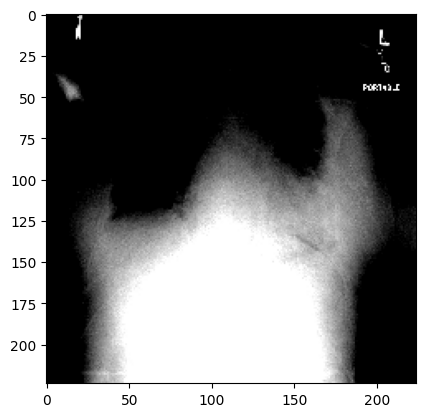

In [84]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);


In [85]:
y # para um batch_size=X

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies